<a href="https://colab.research.google.com/github/educanto/visaoComputacional/blob/main/classic_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Identificação de Manchas em Câmeras de Segurança*
## *Stain Identification in Security Cameras*  
* Métodos Clássicos de Visão Computacional




O objetivo deste trabalho é permitir a identificação de manchas na imagem gerada por câmeras de segurança. Isso foi possível utilizando as seguintes técnicas: equalização de histograma, filtro gaussiano, thresholding e rotulação de componentes conexas.

The goal of this project is to allow the identification of stains in the image generated by a security camera. That was possible by using the following approaches: histogram equalization, gaussian-blur filter, thresholding and connected components labelling.

Autores: Eduardo Camilo do Canto e Rafael Quint




In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from ipywidgets import interact, interactive, interact_manual
from copy import deepcopy
import time
from random import randint
import os
import cv2
from skimage.morphology import disk
from skimage.filters import rank
from skimage import data, img_as_float, exposure

import numpy as np

!wget  --backups=1 -q https://raw.githubusercontent.com/awangenh/fastaniso/master/fastaniso.py 

# Import the anisotropic filter 
from fastaniso import *

drive.mount('/content/gdrive')

# Write here your working directory
root_path = '/content/gdrive/MyDrive/Visão Computacional/Trabalho'

In [ ]:
def simple_plot(imgs, titles, size=(16,8), rows=1):
    if rows == 1:
        fig, axes = plt.subplots(ncols=len(imgs), figsize=size, sharex=True, sharey=True)
    else:
        fig, axes = plt.subplots(ncols=len(imgs)//2+1, nrows=rows, figsize=size, sharex=True, sharey=True)

    if len(imgs) >= 2:
        axes = axes.ravel()

        for i, img in enumerate(imgs):
            axes[i].imshow(img, cmap=plt.cm.gray)
            axes[i].set_title(titles[i])
            axes[i].set_axis_off()
    else:
        axes.imshow(imgs[0], cmap=plt.cm.gray)
        axes.set_title(titles[0])
        axes.set_axis_off()


    fig.tight_layout()
    plt.show()


def local_equalize(img, disksize):
    selem = disk(disksize)
    img_eq = rank.equalize(img, selem=selem)
    return(img_eq)

def connectedComponents(img, orig_img):

	numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img)

	classified_img = deepcopy(orig_img)

	for i in range(0, numLabels):
		if i == 0:
			text = "examining component {}/{} (background)".format(i + 1, numLabels)
		else:
			text = "examining component {}/{}".format( i + 1, numLabels)
	
			x = stats[i, cv2.CC_STAT_LEFT]
			y = stats[i, cv2.CC_STAT_TOP]
			w = stats[i, cv2.CC_STAT_WIDTH]
			h = stats[i, cv2.CC_STAT_HEIGHT]
			area = stats[i, cv2.CC_STAT_AREA]
			(cX, cY) = centroids[i]
			# print(x,y,w,h)
		
			cv2.rectangle(classified_img, (x-15, y-15), (x + w+15, y + h+15), (255, 0, 0), 1)
			cv2.circle(classified_img, (int(cX), int(cY)), 2, (0, 0, 255), -1)
		
		# print("[INFO] {}".format(text))

	if numLabels > 1:
		return False, classified_img
	else:
		return True, classified_img


def classifyImage(img):
    disk_kernel_size = int(img.shape[0] * 0.06)
    img_hist = local_equalize(img, disk_kernel_size)
    img_gauss = cv2.GaussianBlur(img_hist, ksize = (21, 21), sigmaX = 2.8)

    th, img_th = cv2.threshold(img_gauss, 70, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5,5),np.uint8)
    img_opened = cv2.morphologyEx(img_th, cv2.MORPH_OPEN, kernel)
    kernel2 = np.ones((7,7),np.uint8)
    img_th_closed = cv2.morphologyEx(img_opened, cv2.MORPH_CLOSE, kernel2)

    result, final_img = connectedComponents(img_th_closed, img)

    return result, final_img

# **Image Selection**

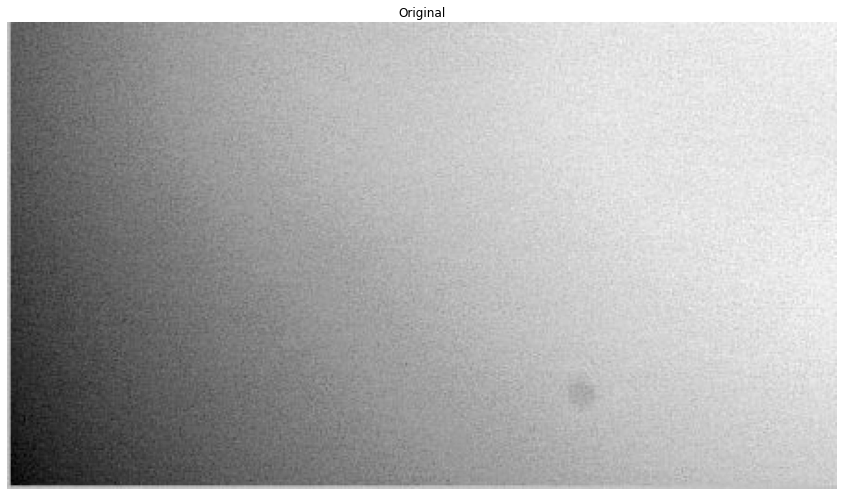

In [ ]:
# Choose a specific image from the dataset
img_path = '/mancha'
img_file = '/09_12_2021__17_37_12_10_f3.jpg'

# # Choose a random image from the dataset
# img_path = '/mancha/'                   
# files = os.listdir(root_path + img_path)
# i = randint(0, len(files))
# print(files[i])
# img_file = files[i]

# Get image to apply classification
orig_img = cv2.imread(root_path + img_path + img_file, cv2.IMREAD_GRAYSCALE)

# Get the same image to show results
orig_img_color = cv2.imread(root_path + img_path + img_file, cv2.IMREAD_COLOR)
orig_img_color = cv2.cvtColor(orig_img_color, cv2.COLOR_BGR2RGB)

simple_plot([orig_img], ['Original'], (14,7))

# **1 - Local Equalization with Histogram**

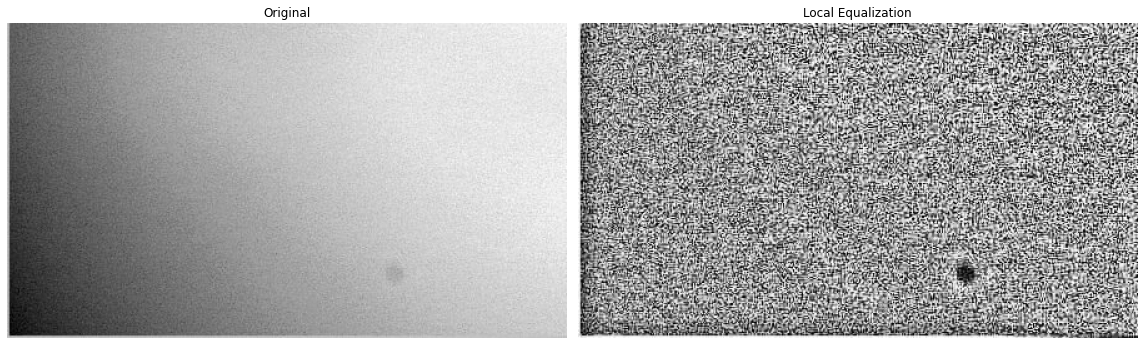

In [ ]:
# Use a disk-shaped kernel for the definition of locality
disk_kernel_size = int(orig_img.shape[0] * 0.06)

img_hist = local_equalize(orig_img, disk_kernel_size)

simple_plot([orig_img, img_hist], ['Original', 'Local Equalization'], (16,8))

# **2 - Gaussian Blur Filter**

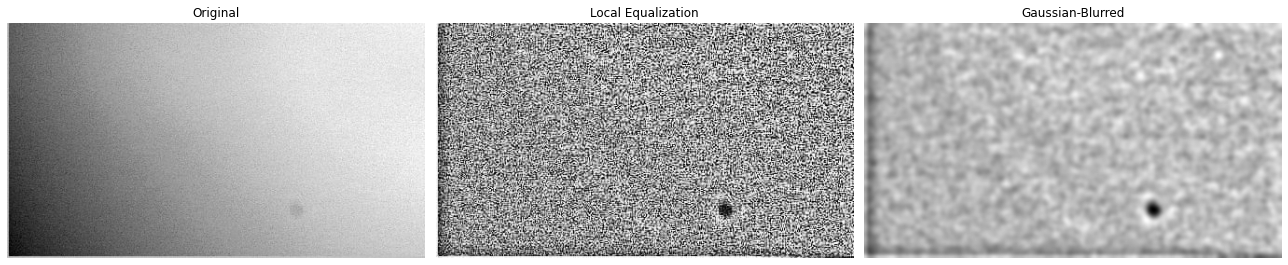

In [ ]:
img_gauss = cv2.GaussianBlur(img_hist, ksize = (21, 21), sigmaX = 2.8)


simple_plot([orig_img, img_hist, img_gauss], ['Original', 'Local Equalization', 'Gaussian-Blurred'], (18,9))

# **3 - Simple Threshold**

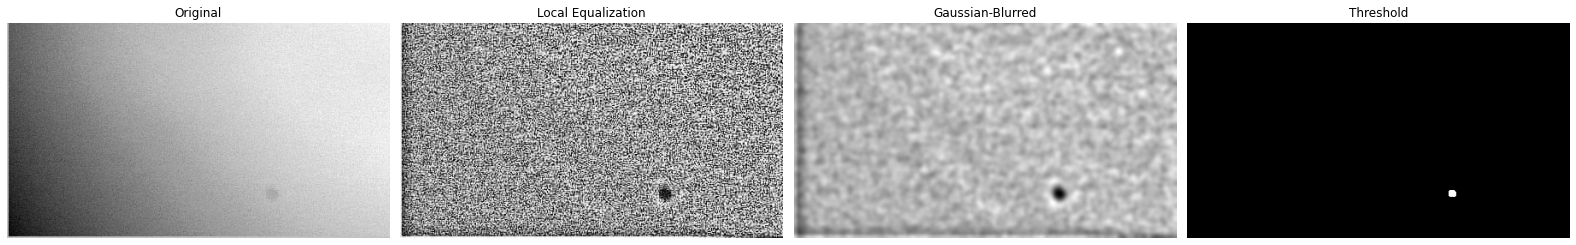

In [ ]:
th, img_th = cv2.threshold(img_gauss, 70, 255, cv2.THRESH_BINARY_INV)

## Fine tunning:

# Open the Mask with the Kernel
kernel = np.ones((5,5),np.uint8)
img_opened = cv2.morphologyEx(img_th, cv2.MORPH_OPEN, kernel)

# Close the Mask with the Kernel
kernel2 = np.ones((7,7),np.uint8)
img_th_closed = cv2.morphologyEx(img_opened, cv2.MORPH_CLOSE, kernel2)

simple_plot([orig_img, img_hist, img_gauss, img_th_closed], ['Original', 'Local Equalization', 'Gaussian-Blurred', 'Threshold'], (22,11))

# **4 - Connected Components Labeling**

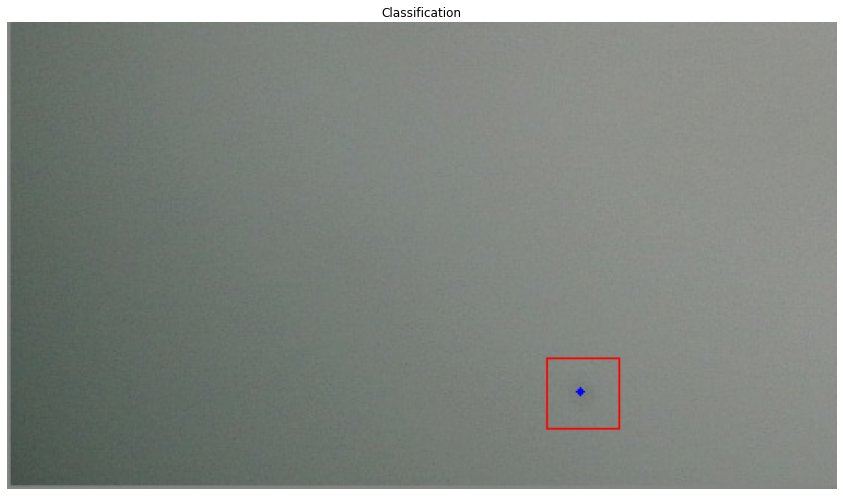

In [ ]:
result, final_img = connectedComponents(img_th_closed, orig_img_color)

simple_plot([final_img], ['Classification'], (14,7))

**Plot results**

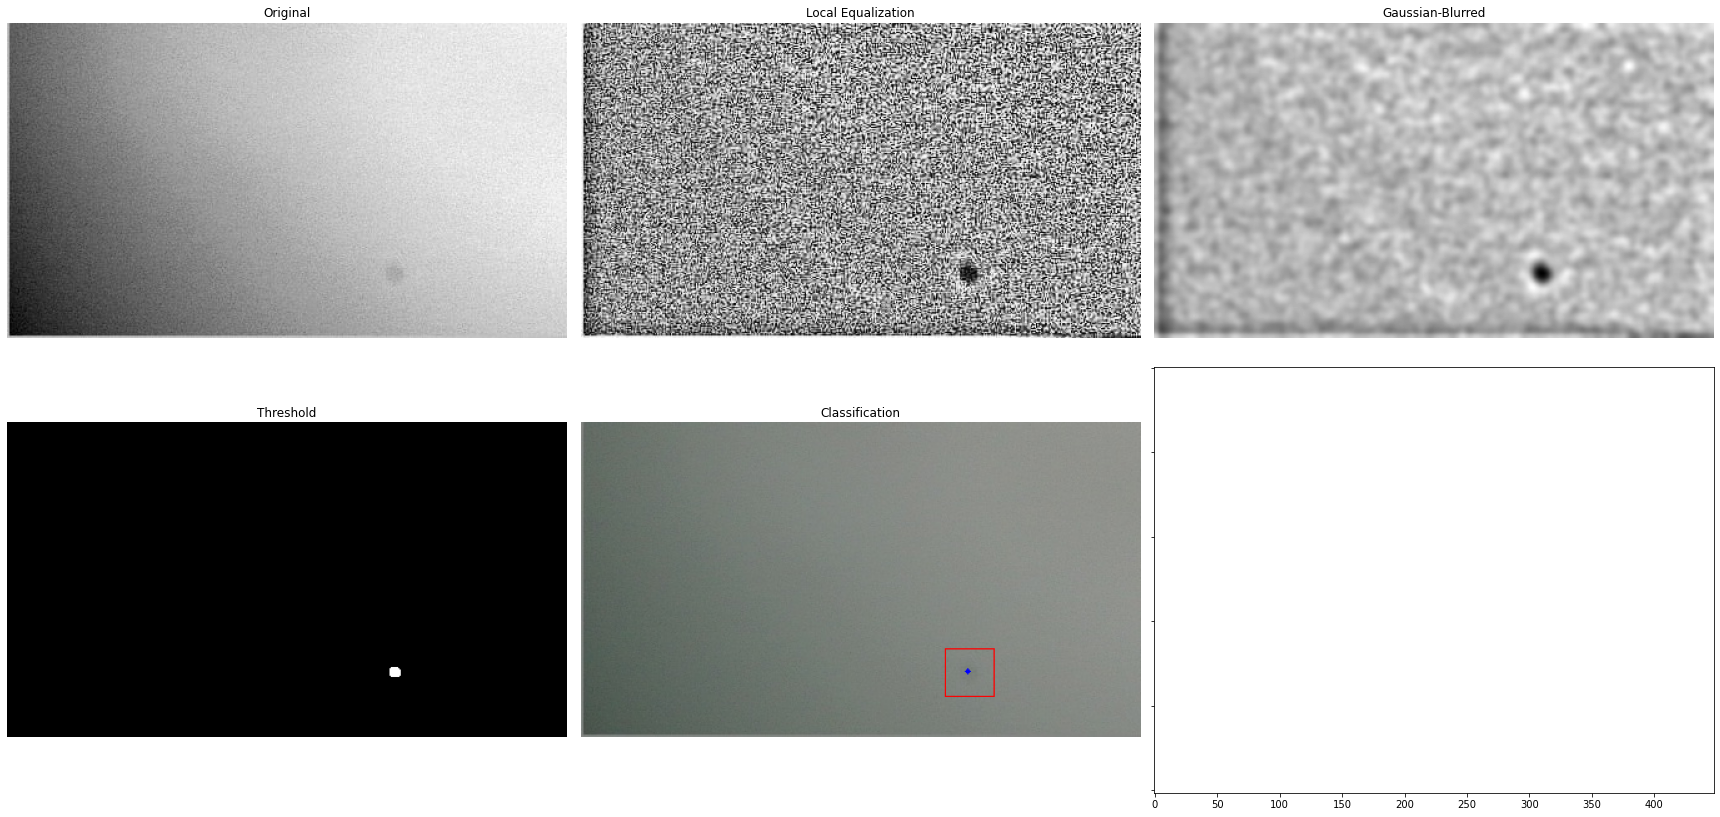

In [ ]:
simple_plot([orig_img, img_hist, img_gauss, img_th_closed, final_img], ['Original', 'Local Equalization', 'Gaussian-Blurred', 'Threshold','Classification'], (24,12), rows=2)

# **Model performance**

normal
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_52_54_10_f0.jpg

True positives: 1
True negatives: 0
False positives: 0
False negatives: 0
Average time: 48.04 ms
Total time: 0.05 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__14_23_00_11_f0.jpg

True positives: 2
True negatives: 0
False positives: 0
False negatives: 0
Average time: 51.77 ms
Total time: 0.1 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_25_09_11_f2.jpg

True positives: 3
True negatives: 0
False positives: 0
False negatives: 0
Average time: 48.08 ms
Total time: 0.14 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_56_30_00_f3.jpg

True positives: 4
True negatives: 0
False positives: 0
False negatives: 0
Average time: 44.56 ms
Total time: 0.18 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/25_11_2021__09_20_15_01_f1.jpg

True positives: 5
True negatives: 0
False positives: 0
False negatives

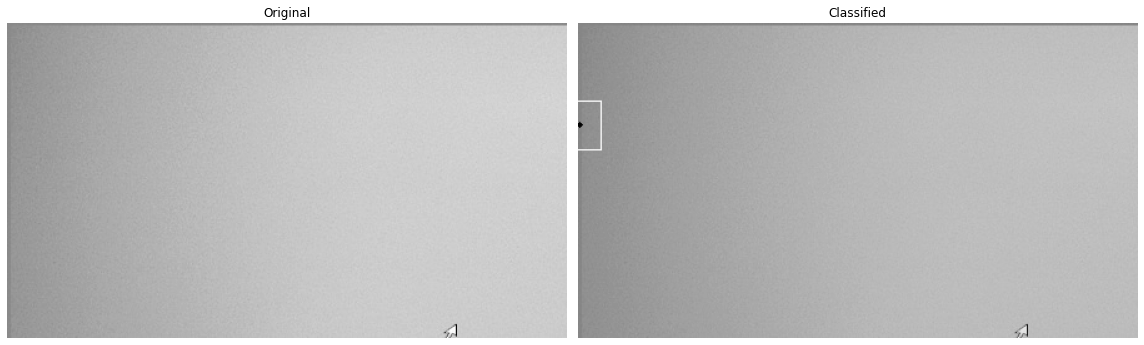


True positives: 15
True negatives: 0
False positives: 0
False negatives: 1
Average time: 38.93 ms
Total time: 0.62 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_55_17_10_f0.jpg

True positives: 16
True negatives: 0
False positives: 0
False negatives: 1
Average time: 39.57 ms
Total time: 0.67 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__14_10_13_10_f1.jpg

True positives: 17
True negatives: 0
False positives: 0
False negatives: 1
Average time: 39.17 ms
Total time: 0.71 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_28_01_01_f0.jpg

True positives: 18
True negatives: 0
False positives: 0
False negatives: 1
Average time: 38.68 ms
Total time: 0.73 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/25_11_2021__09_32_16_00_f0.jpg
Predicted: mancha / Actual: normal


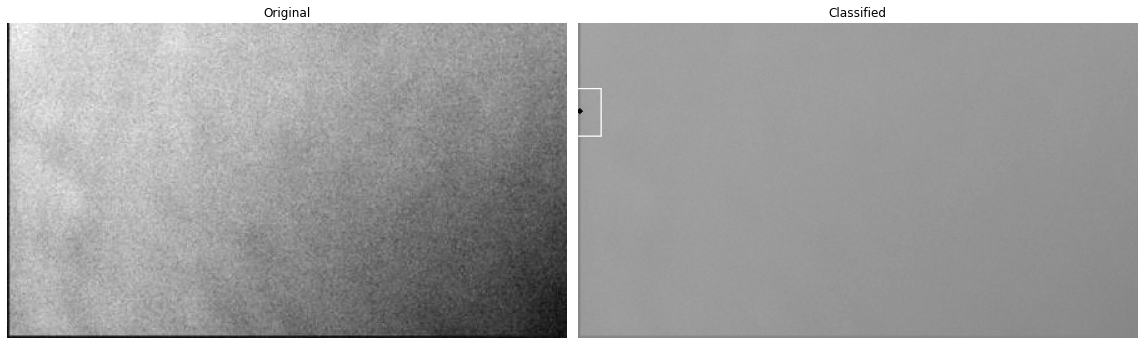


True positives: 18
True negatives: 0
False positives: 0
False negatives: 2
Average time: 38.26 ms
Total time: 0.77 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_56_30_01_f3.jpg

True positives: 19
True negatives: 0
False positives: 0
False negatives: 2
Average time: 39.38 ms
Total time: 0.83 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/25_11_2021__09_25_33_11_f0.jpg

True positives: 20
True negatives: 0
False positives: 0
False negatives: 2
Average time: 39.63 ms
Total time: 0.87 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__12_15_48_10_f0.jpg

True positives: 21
True negatives: 0
False positives: 0
False negatives: 2
Average time: 39.25 ms
Total time: 0.9 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/08_12_2021__09_28_01_10_f3.jpg

True positives: 22
True negatives: 0
False positives: 0
False negatives: 2
Average time: 38.73 ms
Total time: 0.93 s
/content/gdrive/MyDrive/Visão Computacional/Tra

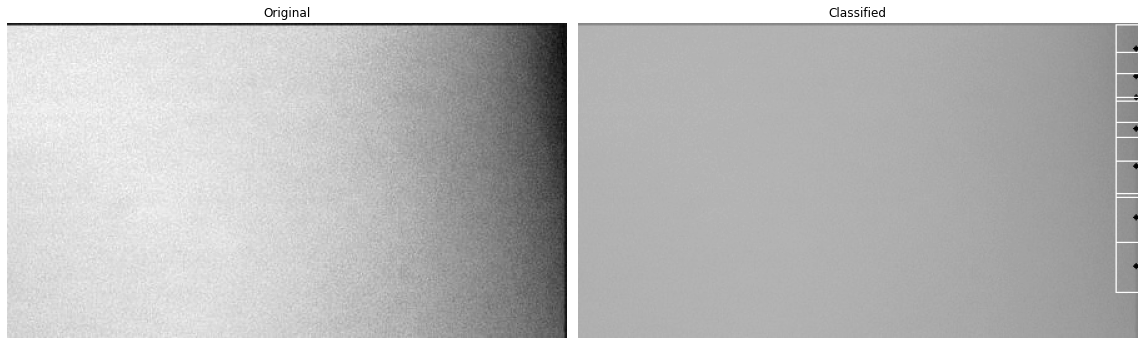


True positives: 69
True negatives: 0
False positives: 0
False negatives: 3
Average time: 34.4 ms
Total time: 2.48 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_28_56_11_f3.jpg

True positives: 70
True negatives: 0
False positives: 0
False negatives: 3
Average time: 34.63 ms
Total time: 2.53 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__14_51_59_10_f0.jpg

True positives: 71
True negatives: 0
False positives: 0
False negatives: 3
Average time: 34.62 ms
Total time: 2.56 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_52_54_00_f1.jpg

True positives: 72
True negatives: 0
False positives: 0
False negatives: 3
Average time: 34.75 ms
Total time: 2.61 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__14_54_27_11_f2.jpg

True positives: 73
True negatives: 0
False positives: 0
False negatives: 3
Average time: 34.68 ms
Total time: 2.64 s
/content/gdrive/MyDrive/Visão Computacional/Tra

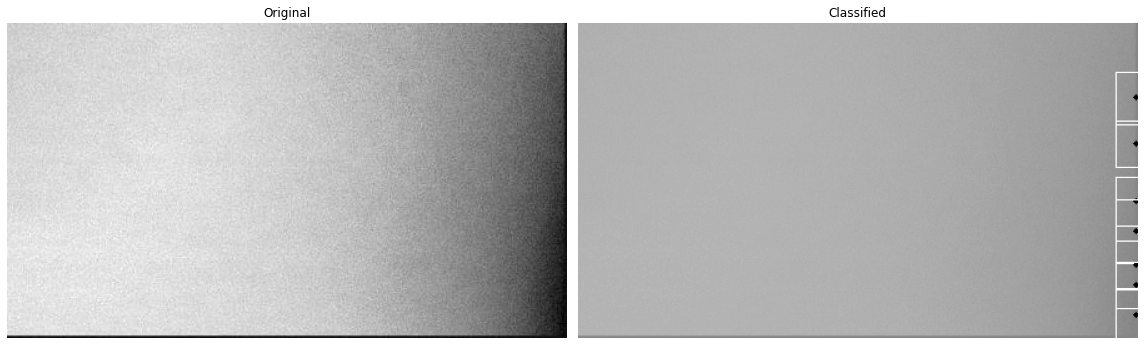


True positives: 91
True negatives: 0
False positives: 0
False negatives: 4
Average time: 34.28 ms
Total time: 3.26 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__13_03_27_10_f0.jpg

True positives: 92
True negatives: 0
False positives: 0
False negatives: 4
Average time: 34.46 ms
Total time: 3.31 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_28_01_01_f2.jpg

True positives: 93
True negatives: 0
False positives: 0
False negatives: 4
Average time: 34.46 ms
Total time: 3.34 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_26_39_10_f1.jpg

True positives: 94
True negatives: 0
False positives: 0
False negatives: 4
Average time: 34.42 ms
Total time: 3.37 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_56_30_10_f3.jpg

True positives: 95
True negatives: 0
False positives: 0
False negatives: 4
Average time: 34.37 ms
Total time: 3.4 s
/content/gdrive/MyDrive/Visão Computacional/Tra

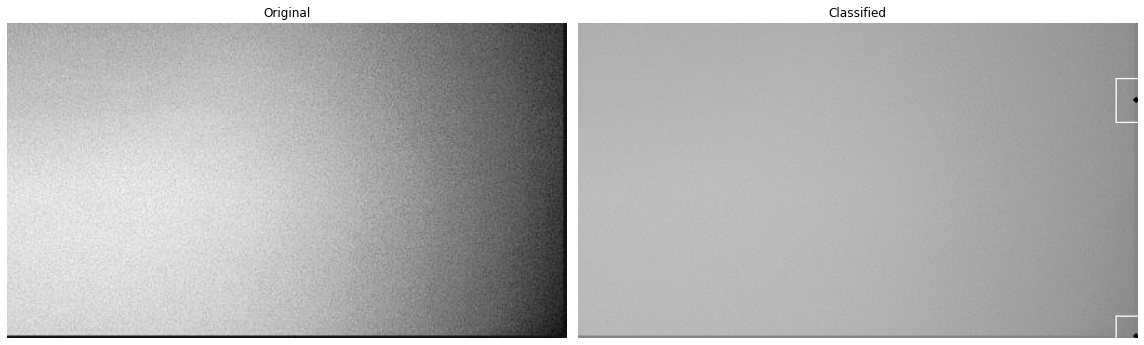


True positives: 122
True negatives: 0
False positives: 0
False negatives: 5
Average time: 34.05 ms
Total time: 4.32 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_29_44_11_f0.jpg

True positives: 123
True negatives: 0
False positives: 0
False negatives: 5
Average time: 34.18 ms
Total time: 4.38 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__14_48_04_11_f2.jpg

True positives: 124
True negatives: 0
False positives: 0
False negatives: 5
Average time: 34.16 ms
Total time: 4.41 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/09_12_2021__16_04_48_01_f2.jpg

True positives: 125
True negatives: 0
False positives: 0
False negatives: 5
Average time: 34.12 ms
Total time: 4.44 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__14_48_04_11_f3.jpg

True positives: 126
True negatives: 0
False positives: 0
False negatives: 5
Average time: 34.09 ms
Total time: 4.47 s
/content/gdrive/MyDrive/Visão Computacion

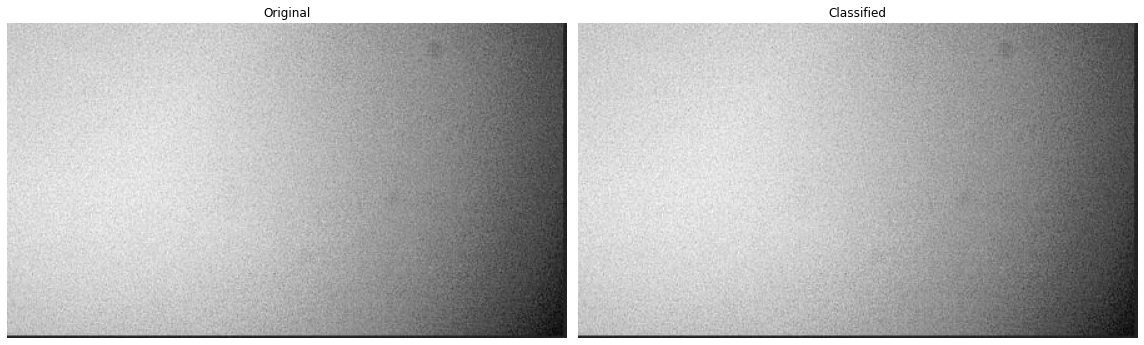


True positives: 441
True negatives: 37
False positives: 1
False negatives: 27
Average time: 34.05 ms
Total time: 17.23 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__13_03_27_11_f2.jpg

True positives: 441
True negatives: 38
False positives: 1
False negatives: 27
Average time: 34.08 ms
Total time: 17.28 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__14_39_26_10_f0.jpg

True positives: 441
True negatives: 39
False positives: 1
False negatives: 27
Average time: 34.1 ms
Total time: 17.33 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__12_37_19_11_f3.jpg

True positives: 441
True negatives: 40
False positives: 1
False negatives: 27
Average time: 34.1 ms
Total time: 17.36 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/09_12_2021__12_35_45_00_f2.jpg

True positives: 441
True negatives: 41
False positives: 1
False negatives: 27
Average time: 34.09 ms
Total time: 17.39 s
/content/gdrive/MyDrive/Visã

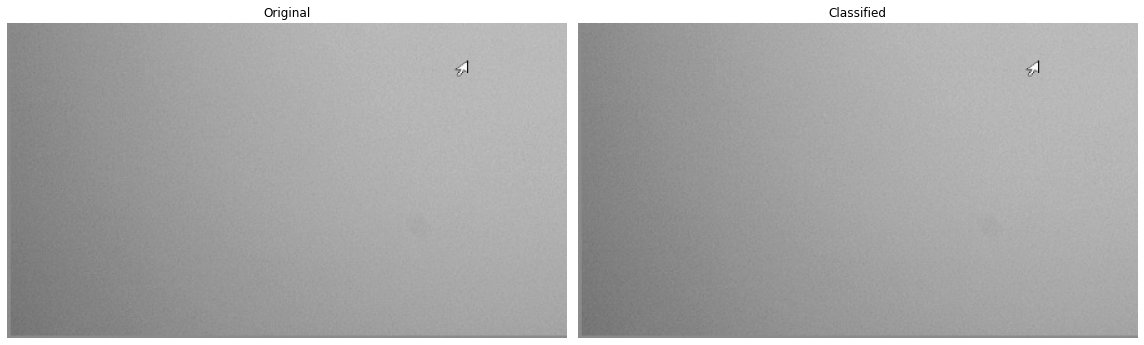


True positives: 441
True negatives: 41
False positives: 2
False negatives: 27
Average time: 34.1 ms
Total time: 17.42 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__12_37_19_01_f2.jpg

True positives: 441
True negatives: 42
False positives: 2
False negatives: 27
Average time: 34.14 ms
Total time: 17.48 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/22_11_2021__15_00_19_00_f2.jpg

True positives: 441
True negatives: 43
False positives: 2
False negatives: 27
Average time: 34.14 ms
Total time: 17.51 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/22_11_2021__15_01_12_11_f1.jpg
Predicted: normal / Actual: mancha


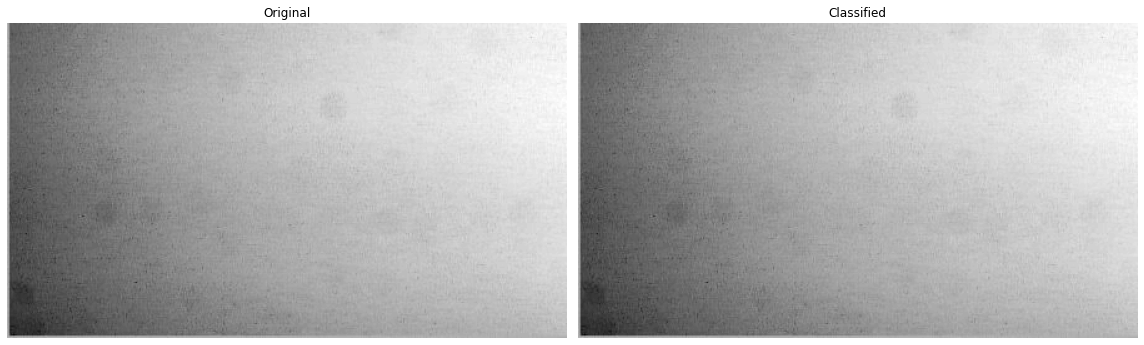


True positives: 441
True negatives: 43
False positives: 3
False negatives: 27
Average time: 34.13 ms
Total time: 17.54 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__12_21_21_11_f1.jpg

True positives: 441
True negatives: 44
False positives: 3
False negatives: 27
Average time: 34.16 ms
Total time: 17.59 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__12_31_06_11_f2.jpg

True positives: 441
True negatives: 45
False positives: 3
False negatives: 27
Average time: 34.15 ms
Total time: 17.62 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/22_11_2021__14_43_42_10_f3.jpg

True positives: 441
True negatives: 46
False positives: 3
False negatives: 27
Average time: 34.14 ms
Total time: 17.65 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/25_11_2021__09_04_15_01_f0.jpg

True positives: 441
True negatives: 47
False positives: 3
False negatives: 27
Average time: 34.14 ms
Total time: 17.68 s
/content/gdrive/MyDrive/Vi

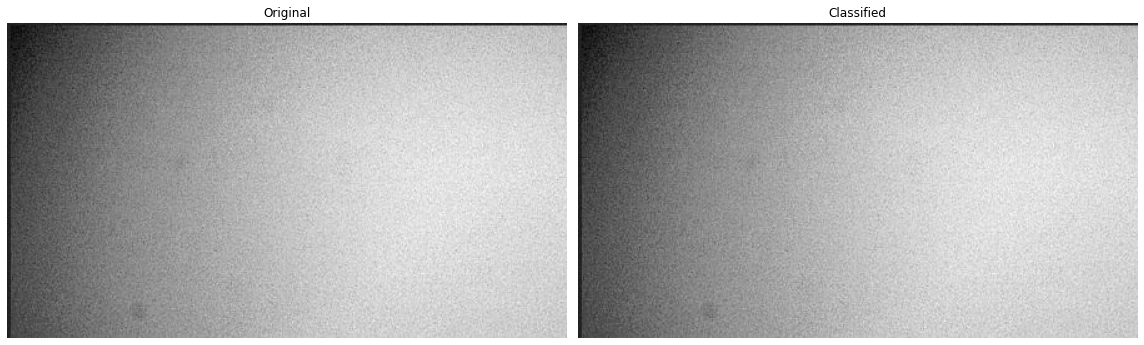


True positives: 441
True negatives: 48
False positives: 4
False negatives: 27
Average time: 34.14 ms
Total time: 17.75 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__13_10_51_11_f1.jpg

True positives: 441
True negatives: 49
False positives: 4
False negatives: 27
Average time: 34.18 ms
Total time: 17.81 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__13_06_45_11_f2.jpg

True positives: 441
True negatives: 50
False positives: 4
False negatives: 27
Average time: 34.18 ms
Total time: 17.84 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__13_09_43_00_f2.jpg

True positives: 441
True negatives: 51
False positives: 4
False negatives: 27
Average time: 34.17 ms
Total time: 17.87 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/22_11_2021__14_47_51_01_f1.jpg

True positives: 441
True negatives: 52
False positives: 4
False negatives: 27
Average time: 34.17 ms
Total time: 17.9 s
/content/gdrive/MyDrive/Vis

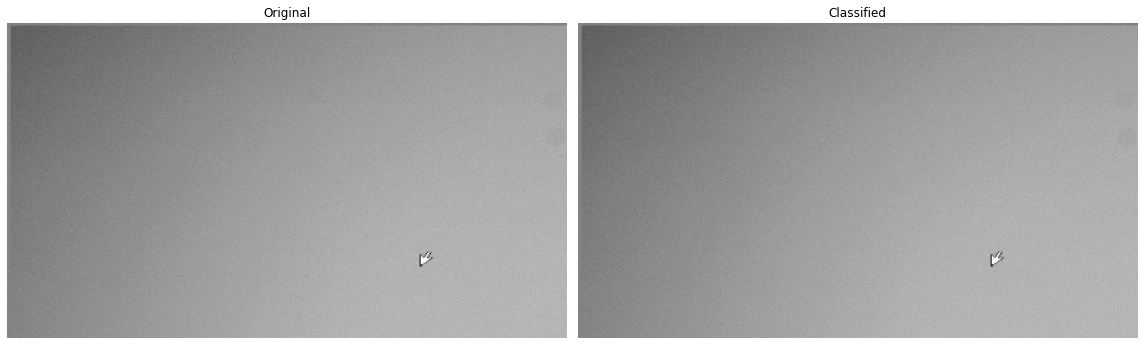


True positives: 441
True negatives: 59
False positives: 5
False negatives: 27
Average time: 34.19 ms
Total time: 18.19 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__12_41_57_11_f0.jpg

True positives: 441
True negatives: 60
False positives: 5
False negatives: 27
Average time: 34.22 ms
Total time: 18.24 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/06_12_2021__14_55_49_11_f3.jpg

True positives: 441
True negatives: 61
False positives: 5
False negatives: 27
Average time: 34.23 ms
Total time: 18.28 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/22_11_2021__14_45_05_10_f3.jpg

True positives: 441
True negatives: 62
False positives: 5
False negatives: 27
Average time: 34.23 ms
Total time: 18.31 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/mancha/22_11_2021__14_52_13_01_f0.jpg

True positives: 441
True negatives: 63
False positives: 5
False negatives: 27
Average time: 34.24 ms
Total time: 18.35 s
/content/gdrive/MyDrive/Vi

In [ ]:
# The classification is applied to all images in the dataset

classes_folders = []
files = os.listdir(root_path)
for file in files:
    if os.path.isdir(root_path + '/' + file):
        classes_folders.append(file)

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

tests_time = []

for class_folder in classes_folders:
    counter = 0
    print(class_folder)
    imgs = os.listdir(root_path + '/' + class_folder)
    for img in imgs:
        if '.jpg' not in img:   # Exclude non-image files
            continue

        path = root_path + '/' + class_folder + '/' + img

        if 'mancha' in path:
            actual_result = False
        else:
            actual_result = True

        print(path)
        frame = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        init_time = time.time()
        result, final_img = classifyImage(frame)    # Run classification process
        test_time = time.time() - init_time

        tests_time.append(test_time)
        
        # Evaluate the results and plot some of them
        if actual_result == True and result == True:
            true_positives += 1
        elif actual_result == False and result == False:
            true_negatives += 1
        elif actual_result == False and result == True:
            false_positives += 1
            if counter < 5:
                counter += 1
                print('Predicted: normal / Actual: mancha')
                simple_plot([frame, final_img], ['Original', 'Classified'])
        elif actual_result == True and result == False:
            false_negatives += 1
            if counter < 5:
                counter += 1
                print('Predicted: mancha / Actual: normal')
                simple_plot([frame, final_img], ['Original', 'Classified'])


        print('\nTrue positives: ' + str(true_positives) +
                '\nTrue negatives: ' + str(true_negatives) +
                '\nFalse positives: ' + str(false_positives) +
                '\nFalse negatives: ' + str(false_negatives) +
                '\nAverage time: ' + str(round(1000*sum(tests_time)/len(tests_time),2)) + ' ms'
                '\nTotal time: ' + str(round(sum(tests_time),2)) + ' s')

print('\nfinished')

# Calcule the accuracy
accuracy = round(100*(true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives),2)

print('\n\nAccuracy: ' + str(accuracy) + ' %' +
      '\nTotal time: ' + str(round(sum(tests_time),2)) + ' s')

